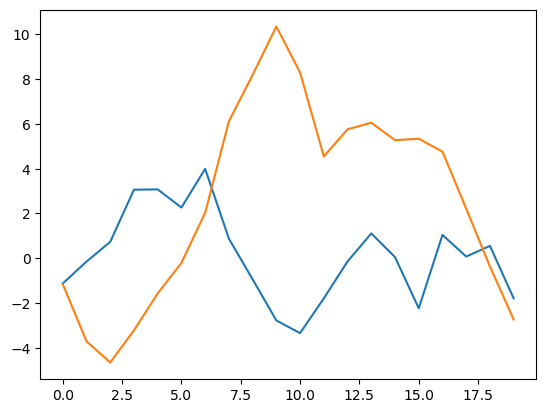

In [3]:
import torch
import matplotlib.pyplot as plt


# Assuming 'vectors' is the input tensor of shape (m, n)
def interpolate_vectors(vectors, num_vectors):
    # Perform linear interpolation to generate the required number of vectors
    interpolated_vectors = torch.nn.functional.interpolate(
        vectors.T.unsqueeze(0), size=num_vectors, mode="linear", align_corners=True
    ).squeeze(0).T
    return interpolated_vectors


# Example usage
torch.random.manual_seed(0)
# zeilen sind features, spalten sind zeit
input_vectors = torch.cumsum(torch.randn(100, 2), dim=0)
interpolated_result = interpolate_vectors(input_vectors, 20)
# print(input_vectors)
# plt.plot(input_vectors)
plt.plot(interpolated_result)
plt.show()
# num_desired_vectors = 30  # Desired number of vectors after interpolation
# interpolated_result = interpolate_vectors(input_vectors, num_desired_vectors)
# plt.plot(input_vectors.squeeze())
# plt.plot(interpolated_result.squeeze())
# plt.show()

In [5]:
from utils import MeldDataset, SequenceClassificationCollator, MmLlamaProcessor
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoConfig, AutoProcessor, AutoModel
from tqdm.auto import tqdm

LANGUAGE_MODEL = "/home/fock/code/MultiModalInstructERC/models/language/LLaMA2"
LORA_ADAPTER = "/home/fock/code/MultiModalInstructERC/models/language/adapter/InstructERC_unbalanced"
ACOUSTIC_MODEL = "/home/fock/code/MultiModalInstructERC/models/acoustic/wav2vec2/wav2vec2-large-robust-12-ft-emotion-msp-dim"
OUTPUT_PATH = "/home/fock/code/MultiModalInstructERC/experiments/multimodal/mlp/concat/"
DS_TRAIN_PATH = "/home/fock/code/MultiModalInstructERC/datasets/meld/train_sent_emo.csv"
DS_DEV_PATH = "/home/fock/code/MultiModalInstructERC/datasets/meld/dev_sent_emo.csv"
DS_TEST_PATH = "/home/fock/code/MultiModalInstructERC/datasets/meld/test_sent_emo.csv"



tokenizer = AutoTokenizer.from_pretrained(LANGUAGE_MODEL)
ac_config = AutoConfig.from_pretrained(ACOUSTIC_MODEL)
ac_processor = AutoProcessor.from_pretrained(ACOUSTIC_MODEL)

# setup of tokenizer
tokenizer.add_special_tokens({"additional_special_tokens": ["<audio>"]})
tokenizer.pad_token_id = tokenizer.unk_token_id
tokenizer.padding_side = "left"
processor = MmLlamaProcessor(ac_processor, tokenizer)

train_dataset = MeldDataset(DS_TRAIN_PATH, mode="train", task="normal", window=5)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=SequenceClassificationCollator(processor, mode="train"),
)

wave2vec2 = AutoModel.from_pretrained(ac_config._name_or_path).cuda()


processed_sizes = []
# for batch in tqdm(train_dataloader):
#     acoustic_inputs = batch["acoustic"]
#     acoustic_inputs = {k: v.cuda() for k, v in acoustic_inputs.items()}
#     last_hidden_state = wave2vec2(**acoustic_inputs).last_hidden_state
#     size = last_hidden_state.size()[1]
#     processed_sizes.append(size)
processed_sizes.sort(reverse=True)
print(processed_sizes)


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at /home/fock/code/MultiModalInstructERC/models/acoustic/wav2vec2/wav2vec2-large-robust-12-ft-emotion-msp-dim and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[]


In [34]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=SequenceClassificationCollator(processor, mode="train"),
)
batch1 = next(iter(train_dataloader))
acoustic_inputs = batch1["acoustic"]
acoustic_inputs = {k: v.cuda() for k, v in acoustic_inputs.items()}
with torch.no_grad():
    last_hidden_state = wave2vec2(**acoustic_inputs).last_hidden_state.cpu()
print(last_hidden_state.shape)

torch.Size([8, 324, 1024])


In [53]:
from sklearn.decomposition import PCA
import numpy as np

def apply_pca(pca, last_hidden_state):
    lhs = last_hidden_state.reshape(-1, last_hidden_state.shape[-1])
    lhs = pca.transform(lhs)
    lhs = lhs.reshape(last_hidden_state.shape[0], last_hidden_state.shape[1], -1)
    return lhs

pca = PCA(n_components=2)
pca = pca.fit(last_hidden_state.reshape(-1, last_hidden_state.shape[-1]))
lhs5 = apply_pca(pca, last_hidden_state)

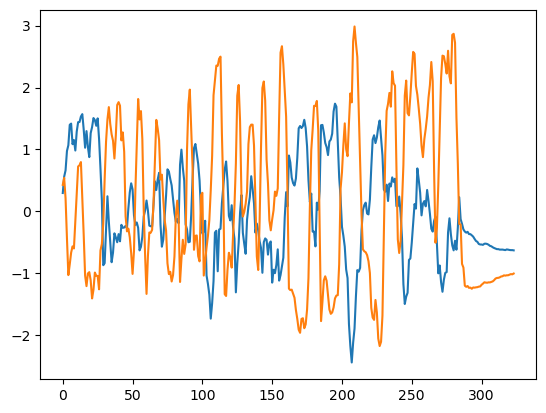

In [54]:
plt.plot(lhs5[0])
plt.show()

In [57]:
def interpolate_vectors(vectors, num_vectors):
    interpolated_vectors = torch.nn.functional.interpolate(
        torch.swapaxes(vectors, 1,2), size=num_vectors, mode="linear", align_corners=True
    )
    return torch.swapaxes(interpolated_vectors, 1,2)

interpolated_result = interpolate_vectors(last_hidden_state, 100)
interpolated_result.shape

torch.Size([8, 100, 1024])

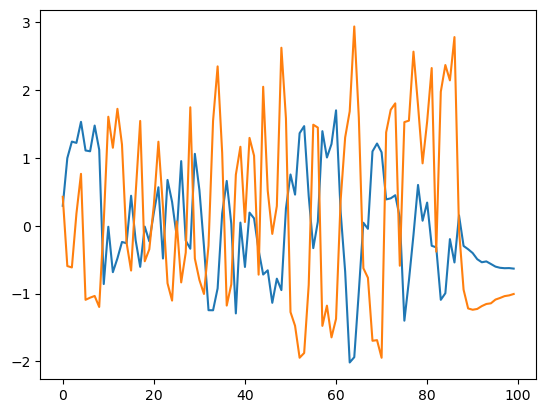

In [58]:
lhs_interpolated = apply_pca(pca, interpolated_result)
plt.plot(lhs_interpolated[0])
plt.show()

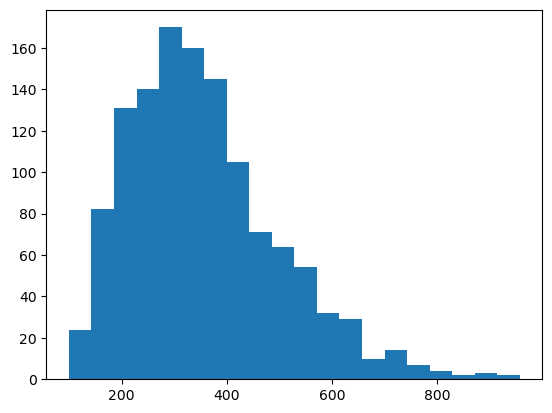

In [4]:
plt.hist(processed_sizes, bins=20)
plt.show()

In [6]:
batch1 = next(iter(train_dataloader))
acoustic_inputs = batch1["acoustic"]
acoustic_inputs = {k: v.cuda() for k, v in acoustic_inputs.items()}
embeddings = wave2vec2(**acoustic_inputs).last_hidden_state
embeddings.shape

torch.Size([8, 402, 1024])

  0%|          | 0/9988 [00:00<?, ?it/s]

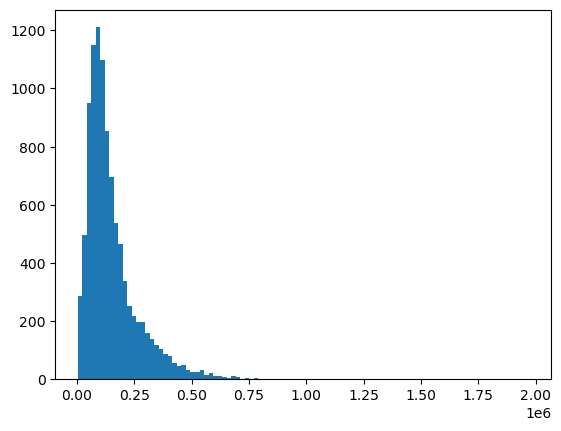

In [6]:

import torchaudio
from glob import glob
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

paths = glob("/home/fock/code/MultiModalInstructERC/datasets/meld/audio/train/*.wav")

a = [torchaudio.info(path).num_frames for path in tqdm(paths)]

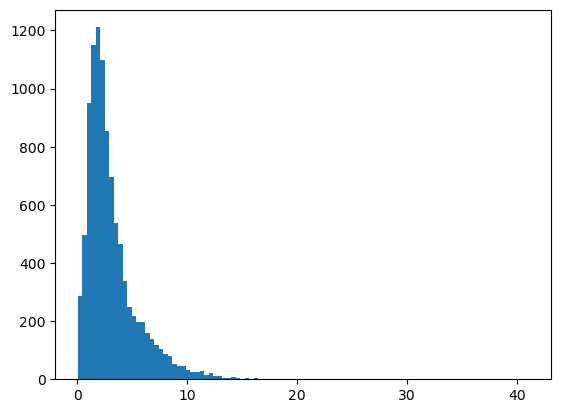

In [7]:
import numpy as np


b = np.array(a)
b = b / 48000
plt.hist(b, bins=100)
plt.show()

In [59]:
import numpy as np
import torch
import torch.nn as nn
from transformers import Wav2Vec2Processor
from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2Model,
    Wav2Vec2PreTrainedModel,
)


class RegressionHead(nn.Module):
    r"""Classification head."""

    def __init__(self, config):

        super().__init__()

        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):

        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)

        return x


class EmotionModel(Wav2Vec2PreTrainedModel):
    r"""Speech emotion classifier."""

    def __init__(self, config):

        super().__init__(config)

        self.config = config
        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = RegressionHead(config)
        self.init_weights()

    def forward(
            self,
            input_values,
    ):

        outputs = self.wav2vec2(input_values)
        hidden_states = outputs[0]
        hidden_states = torch.mean(hidden_states, dim=1)
        logits = self.classifier(hidden_states)

        return hidden_states, logits



# load model from hub
device = 'cpu'
model_name = 'audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim'
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = EmotionModel.from_pretrained(model_name)

# dummy signal
sampling_rate = 16000
signal = np.zeros((1, sampling_rate), dtype=np.float32)


def process_func(
    x: np.ndarray,
    sampling_rate: int,
    embeddings: bool = False,
) -> np.ndarray:
    r"""Predict emotions or extract embeddings from raw audio signal."""

    # run through processor to normalize signal
    # always returns a batch, so we just get the first entry
    # then we put it on the device
    y = processor(x, sampling_rate=sampling_rate)
    y = y['input_values'][0]
    y = y.reshape(1, -1)
    y = torch.from_numpy(y).to(device)

    # run through model
    with torch.no_grad():
        y = model(y)[0 if embeddings else 1]

    # convert to numpy
    y = y.detach().cpu().numpy()

    return y


print(process_func(signal, sampling_rate))
#  Arousal    dominance valence
# [[0.5460754  0.6062266  0.40431657]]

print(process_func(signal, sampling_rate, embeddings=True))
# Pooled hidden states of last transformer layer
# [[-0.00752167  0.0065819  -0.00746342 ...  0.00663632  0.00848748
#    0.00599211]]


/home/fock/code/MultiModalInstructERC/.conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EmotionModel were not initialized from the model checkpoint at audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[[0.54607517 0.6062263  0.40431613]]
[[-0.00752167  0.00658191 -0.00746341 ...  0.00663632  0.00848749
   0.00599211]]


In [1]:
from peft import LoraConfig, get_peft_model
from transformers import AutoConfig, LlamaForCausalLM
from utils.model import MmLlama, MmLlamaConfig
import torch.nn as nn

def load_model_for_stage_2(model: nn.Module):
    lora_config = LoraConfig(
        # task_type="CAUSAL_LM",
        r=32,
        lora_alpha=16,
        lora_dropout=0.1,
        target_modules=".*?[qkvo]_proj",
        bias="none",
    )
    model = get_peft_model(model, lora_config)
    # model.unfreeze_projector()
    return model


In [2]:

# Load configurations
llm_config = AutoConfig.from_pretrained("/home/fock/code/MultiModalInstructERC/models/language/LLaMA2")
ac_config = AutoConfig.from_pretrained("/home/fock/code/MultiModalInstructERC/models/acoustic/wav2vec2/wav2vec2-large-robust-12-ft-emotion-msp-dim")

## setup of config
config = MmLlamaConfig(
    llm_config, ac_config, -1, 0, "/home/fock/code/MultiModalInstructERC/models/language/adapter/InstructERC_unbalanced"
)
model = MmLlama(config, train_llm=True)
# model = LlamaForCausalLM.from_pretrained("/home/fock/code/MultiModalInstructERC/models/language/LLaMA2").half()
print(model)

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

/home/fock/code/MultiModalInstructERC/.conda/lib/python3.11/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
Unloading and merging model: 100%|██████████| 550/550 [00:02<00:00, 198.99it/s]
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at /home/fock/code/MultiModalInstructERC/models/acoustic/wav2vec2/wav2vec2-large-robust-12-ft-emotion-msp-dim and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MmLlama(
  (llama): LlamaForCausalLM(
    (model): LlamaModel(
      (embed_tokens): Embedding(0, 4096)
      (layers): ModuleList(
        (0-31): 32 x LlamaDecoderLayer(
          (self_attn): LlamaSdpaAttention(
            (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
            (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
            (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
            (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
            (rotary_emb): LlamaRotaryEmbedding()
          )
          (mlp): LlamaMLP(
            (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
            (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
            (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): LlamaRMSNorm()
          (post_attention_layernorm): LlamaRMSNorm()
   

In [4]:
model = load_model_for_stage_2(model)
model.print_trainable_parameters()
# for name, params in model.named_parameters():
#     if params.requires_grad:
#         print(name)


# print(model)
model.save_pretrained("/home/fock/code/MultiModalInstructERC/experiments/multimodal/mlp/concat")

trainable params: 35,913,728 || all params: 6,697,449,088 || trainable%: 0.5362


: 

In [66]:


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(768, 768)
        self.fc2 = nn.Linear(768, 768)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
class MySecondModel(nn.Module):
    def __init__(self):
        super(MySecondModel, self).__init__()
        self.llama = LlamaForCausalLM.from_pretrained("/home/fock/code/MultiModalInstructERC/models/language/LLaMA2").half()
        self.fc21 = nn.Linear(768, 768)
        self.fc22 = nn.Linear(768, 768)

    def forward(self, x):
        x = self.llama(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
    # def state_dict(self, *args, **kwargs):
    #     print(args, kwargs)
    #     return {}
    
model = MySecondModel()
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=".*?llama.*?[qkvo]_proj",
    bias="none",
)
model = get_peft_model(model, lora_config)
# model.print_trainable_parameters()
print(model.state_dict().keys())
# print(model)
# model.save_pretrained("/home/fock/code/MultiModalInstructERC/experiments/multimodal/mlp/concat")

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

odict_keys(['base_model.model.llama.model.embed_tokens.weight', 'base_model.model.llama.model.layers.0.self_attn.q_proj.base_layer.weight', 'base_model.model.llama.model.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.llama.model.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.llama.model.layers.0.self_attn.k_proj.base_layer.weight', 'base_model.model.llama.model.layers.0.self_attn.k_proj.lora_A.default.weight', 'base_model.model.llama.model.layers.0.self_attn.k_proj.lora_B.default.weight', 'base_model.model.llama.model.layers.0.self_attn.v_proj.base_layer.weight', 'base_model.model.llama.model.layers.0.self_attn.v_proj.lora_A.default.weight', 'base_model.model.llama.model.layers.0.self_attn.v_proj.lora_B.default.weight', 'base_model.model.llama.model.layers.0.self_attn.o_proj.base_layer.weight', 'base_model.model.llama.model.layers.0.self_attn.o_proj.lora_A.default.weight', 'base_model.model.llama.model.layers.0.self_attn.o_proj.lora_B.default.w